# Lorenz 96 + ETKF with ensemble downsizing


In [1]:
# Specify data directory which includes `set_params.py`
data_dir = "data/test"


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from lorenz96_cython import rk4_cython
from lorenz96_cython import lorenz96_cython
# from da.loss import loss_rms
# from da.visualize import plot_loss
from da.etkf import ETKF
import visualize as vis
from util import load_params

In [3]:
import os

# Use the function to load the parameters
set_params = load_params(data_dir)

# Access the parameters
J = set_params.J
F = set_params.F
dt = set_params.dt
N = set_params.N
obs_per = set_params.obs_per
# Nt = set_params.Nt
T_inf = set_params.T_inf
r = set_params.r
N_spinup = set_params.N_spinup
m_reduced_list = set_params.m_reduced_list
alpha_list = set_params.alpha_list
seeds = set_params.seeds

# print params
print(f"Number of variables: {J}")
print(f"Model parameter F: {F}")
print(f"Time step size: {dt}")
print(f"Number of time steps for nature run: {N}")
print(f"Number of time steps per which observations are obtatined: {obs_per}")
# print(f"Number of time steps for OSSE: {Nt}")
print(f"Length of the spin-up period: {N_spinup}")
print(f"Start Time to evaluate the quality of OSSE: {T_inf}")
print(f"Std. of observation noise: {r}")
print(f"List of number of ensemble members: {m_reduced_list}")
print(f"List of inflation factors: {alpha_list}")
print(f"List of random seeds: {seeds}")

Number of variables: 40
Model parameter F: 8
Time step size: 0.01
Number of time steps for nature run: 3600
Number of time steps per which observations are obtatined: 5
Length of the spin-up period: 180
Start Time to evaluate the quality of OSSE: 360
Std. of observation noise: 0.01
List of number of ensemble members: [13, 14, 15]
List of inflation factors: [1.1]
List of random seeds: [0]


## Lorenz 96
When $ J = 40 $, $ F = 8 $ -> 13 positive Lyapunov exponents.

### Generate test data

In [4]:
# generate data
from main import generate_trajectory
try:
    savename_x_true = f'{data_dir}/x_true_l96'
    x_true = np.load(savename_x_true + '.npy')
    print('x_true_l96.npy loaded')
except:
    print('compute x_true_l96')
    savename_x_true = generate_trajectory(J, F, dt, N, obs_per, data_dir)
    x_true = np.load(f'{data_dir}/x_true_l96.npy')

compute x_true_l96
(J, F): (40, 8)
dt: 0.01
N: 3600
save data/test/x_true_l96.npy
x_true.shape (720, 40)


## DA setting

In [5]:
# assimilation period
Dt = obs_per*dt


# Model function for EnKF
p = (np.ones(J) * F,) # parameters for the model

# def M(x, Dt):
#     for _ in range(int(Dt/dt)):
#         x = rk4(lorenz96, 0, x, p, dt)
#     return x

def M_cython(x, Dt):
    for _ in range(int(Dt/dt)):
        x = rk4_cython(lorenz96_cython, 0, x, *p, dt)
    return x

# 観測
H_diag = np.ones(J)
H = np.diag(H_diag)
print("diag of H:", H_diag)
print("rank(H):", np.linalg.matrix_rank(H))

# Model error covariance
Q = np.zeros((J, J))

# Observation error covariance
print("r:", r)
R = r**2*np.eye(J)


# generate observation
x_true = np.load(f'{data_dir}/x_true_l96.npy')

# initial ensemble size
m0 = J+1

diag of H: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
rank(H): 40
r: 0.01


## ETKF with ensemble reduction
To see that "good" initial ensemble and accurate observation provide stably accurate state estimation.
(Motivated by Tokman-Hunt 2013)

Assume extremely accurate observation.
1. Assimilate until `n=N_spinup` with large ensemble.
2. After ensemble mean reaches to the truth, reduce ensemble using SVD.

### Single test run

In [6]:
# ===============================
# Params: m, alpha, seed
# ===============================
from util import reduce_by_svd, reduce_by_sample, npsave
from da.etkf import ETKF

print("single test run")

# set params
seed = 0 # random seed
m_reduced = 14 # reduced ensemble size
alpha = 1.1 # inflation factor

# generate obs
np.random.seed(seed)
y = (H @ x_true.T).T
y += np.random.normal(loc=0, scale=r, size=y.shape)  # assume R = r^2*I

# generate initial ensemble
x_0 = x_true[np.random.randint(len(x_true) - 1)]
P_0 = 25 * np.eye(J)
X_0 = x_0 + np.random.multivariate_normal(
    np.zeros_like(x_0), P_0, m0
)  # (m0, dim_x)

# run spin-up
print("spin-up with m =", m0)
etkf = ETKF(M_cython, H, R, alpha=alpha, store_ensemble=True)
etkf.initialize(X_0)
for y_obs in tqdm(y[: N_spinup]):
    etkf.forecast(Dt)
    etkf.update(y_obs)

# save spin-up data
npsave(f"{data_dir}/xa_spinup_test", etkf.Xa, precision="float32")
# Xa_spinup = etkf.Xa

# reduce ensemble
print("reduce ensemble to m =", m_reduced)
X_reduced = reduce_by_svd(etkf.X, m_reduced)  # by SVD
# X_reduced = reduce_by_sample(etkf.X, m_reduced) # by random sampling
etkf.initialize(X_reduced)
etkf.alpha = alpha
print("assimilation")
for y_obs in tqdm(y[N_spinup:]):
    etkf.forecast(Dt)
    etkf.update(y_obs)

# save data
npsave(f"{data_dir}/xa_test", etkf.Xa, precision="float32")


single test run
spin-up with m = 41


100%|██████████| 180/180 [00:01<00:00, 173.05it/s]


reduce ensemble to m = 14
assimilation


100%|██████████| 540/540 [00:01<00:00, 313.43it/s]


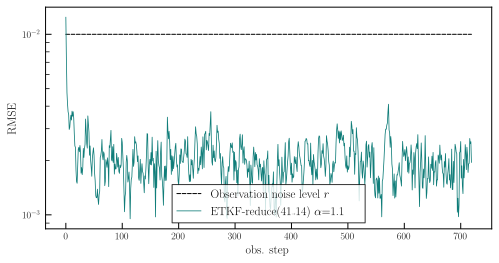

In [7]:
from util import npload
import matplotlib.pyplot as plt
import visualize as vis


plot_per = 1
xa_test = npload(f"{data_dir}/xa_test.npy").mean(axis=1)  # (N, J)
if N_spinup > 0:
    xa_spinup_test = npload(f"{data_dir}/xa_spinup_test.npy").mean(axis=1)  # (N, J)
    xa_test = np.array([*xa_spinup_test, *xa_test])
t = np.arange(0, len(x_true))[::plot_per]
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
# Plot observation noise level
ax.plot(
    t,
    r * np.ones_like(t),
    lw=1,
    c="black",
    ls="--",
    label="Observation noise level $ r $",
)
rmse = np.linalg.norm(x_true - xa_test, axis=-1) / np.sqrt(J)
ax.plot(
    t,
    rmse[::plot_per],
    label=f"ETKF-reduce({m0}→{m_reduced}) $\\alpha$={alpha}",
    lw=0.8,
)
ax.set_xlabel("obs. step")
ax.set_ylabel("RMSE")
ax.set_yscale("log")
ax.legend()

### Loop for m, alpha, seed
The OSSE process above is included into the class `OSSE`.
You can run OSSEs over various parameters `m`, `alpha`, `seed`.

In [8]:
# ===============================
# loop for m, alpha, seed
# ===============================
# RUN OSSE first with large ensemble, then reduce ensemble size
from main import OSSE

osse = OSSE(
        J, F, obs_per, dt, r, N_spinup, m_reduced_list, alpha_list, seeds, data_dir, savename_x_true=savename_x_true
    )
Xa_dict, param_dict = osse.run(parallel="none")

diag of H: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
rank(H): 40
r: 0.01
3 loops
0 0 0
spin-up


100%|██████████| 180/180 [00:01<00:00, 151.95it/s]


assimilation


100%|██████████| 540/540 [00:01<00:00, 384.95it/s]


1 0 0
spin-up


100%|██████████| 180/180 [00:01<00:00, 146.33it/s]


assimilation


100%|██████████| 540/540 [00:01<00:00, 396.01it/s]


2 0 0
spin-up


100%|██████████| 180/180 [00:01<00:00, 134.46it/s]


assimilation


100%|██████████| 540/540 [00:01<00:00, 287.42it/s]


In [9]:
# ========================================
# Load and Compute
# ========================================
import pandas as pd
from util import compute_edims, compute_traceP
# from main import summarize_results
# parameter limsup
# T_inf = 500
print("T_inf", T_inf)

df_sup_se, df_sup_rmse, df_mean_se, df_mean_rmse = osse.summarize_results(T_inf)

T_inf 360
0 0
1 0
2 0


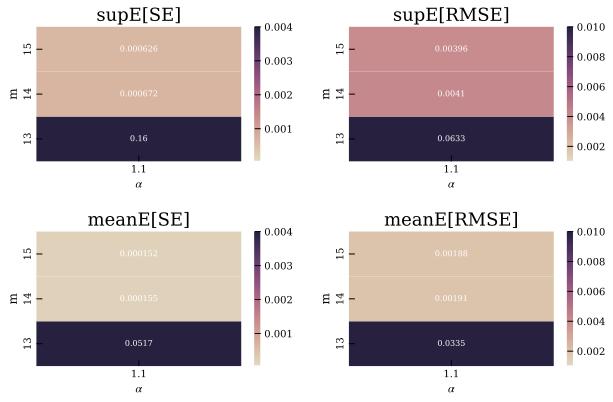

In [10]:
# ========================================
# Plot
# ========================================
plt.rcParams['text.usetex'] = False # 場当たり的な対応
import pandas as pd
import seaborn as sns
cmap = "flare" # flare_r
cmap = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)
fig, ax = plt.subplots(2, 2, figsize=(9, 6))

# load data
df_sup_se = pd.read_csv(f"{data_dir}/sup_se.csv", index_col=0, header=0)
df_mean_rmse = pd.read_csv(f"{data_dir}/mean_rmse.csv", index_col=0, header=0)

ax00 = ax[0, 0]
sns.heatmap(df_sup_se, ax=ax00, vmax=J*r**2, vmin=J*r**2/100, cmap=cmap, annot=True, fmt=".3g", annot_kws={'fontsize': 8, 'color':'white'})
ax00.set_title("supE[SE]")
ax00.set_ylabel("m")
ax00.set_xlabel(r"$ \alpha $")
ax00.invert_yaxis()

ax01 = ax[0, 1]
sns.heatmap(df_sup_rmse, ax=ax01, vmax=r, vmin=r/10, cmap=cmap, annot=True, fmt=".3g", annot_kws={'fontsize': 8, 'color':'white'})
ax01.set_title("supE[RMSE]")
ax01.set_ylabel("m")
ax01.set_xlabel(r"$ \alpha $")
ax01.invert_yaxis()

ax10 = ax[1, 0]
sns.heatmap(df_mean_se, ax=ax10, vmax=J*r**2, vmin=J*r**2/100, cmap=cmap, annot=True, fmt=".3g", annot_kws={'fontsize': 8, 'color':'white'})
ax10.set_title(r"meanE[SE]")
ax10.set_ylabel("m")
ax10.set_xlabel(r"$ \alpha $")
ax10.invert_yaxis()

ax11 = ax[1, 1]
sns.heatmap(df_mean_rmse, ax=ax11, vmax=r, vmin=r/10, cmap=cmap, annot=True, fmt=".3g", annot_kws={'fontsize': 8, 'color':'white'})
ax11.set_title("meanE[RMSE]")
ax11.set_ylabel("m")
ax11.set_xlabel(r"$ \alpha $")
ax11.invert_yaxis()

fig.tight_layout()
# fig.savefig(f"{data_dir}/index.pdf")

plt.show()

<Axes: xlabel='obs. step $n$', ylabel='RMSE'>

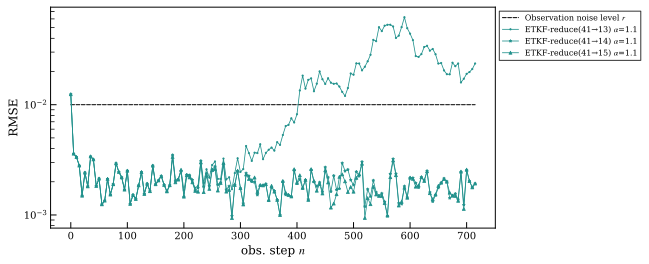

In [11]:
from plot import plot_time_series

# plot params
plot_legend = True # frag to arrange fig
plot_ylabel = True # frag to arrange fig
target_m_list = [13, 14, 15] # m_reduced to plot
target_alpha_list = alpha_list # alpha to plot
plot_type = "one sample" # "one sample", "all sample", "expectation"

plot_time_series(
    data_dir,
    target_m_list,
    target_alpha_list,
    plot_type="one sample",
    plot_ylabel=True,
    plot_legend=True,
    k_seed=0,
    plot_per=5,
    ylabel=None,
    ax=None,
    x_true_path=None,
)